In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize
from scipy.interpolate import interp1d

from datetime import datetime
import pytz

import trfp

central_time = pytz.timezone('US/Central')

matplotlib.rc('xtick', labelsize=10)     
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('axes', labelsize=12)
plt.rcParams["font.family"] = "serif"
sns.set(style="darkgrid")

Welcome to JupyROOT 6.12/04


In [32]:
# Trolley azimuthal uncertainty couples to dm/dphi

# calculate dm/dphi from trolley, run 3956
# interpolate the moment vs phi to standard phi values (36,000 points)

corrected_df = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_corrected_df')
corrected_df = corrected_df.sort_values(by=['tr_phi'])

trm = 'tr,m1'

new_phis = np.arange(3600.)/10
old_phis = np.append(corrected_df['tr_phi'].values - 360,
                     np.append(corrected_df['tr_phi'].values,
                               corrected_df['tr_phi'].values + 360)
                    )
old_ms = np.append(corrected_df[trm].values,
                   np.append(corrected_df[trm].values,
                             corrected_df[trm].values)
                  )

new_ms = interp1d(old_phis, old_ms, kind='slinear')(new_phis)

new_ms = (new_ms + 61.79e6)/42.5774806E6

dm_dphi = (np.roll(new_ms, -1) - np.roll(new_ms, 1))/(2*0.01)
dm_dz = dm_dphi * (1/124.13)  # deg/mm

In [47]:
N = len(new_ms)

print N
new_ms_fft = np.fft.fft(new_ms)/N
fourier_spectrum = np.abs(new_ms_fft)
fourier_angle = np.angle(new_ms_fft, deg=True)

print fourier_spectrum[1]

3600
5.763489805795099e-06


In [48]:
out_df = pd.DataFrame(data=fourier_spectrum[0:500], index=np.arange(0,500), columns=['amplitude'])
out_df['angle'] = fourier_angle[0:500]

In [51]:
out_df.to_csv('dipole_fourier_components.csv', float_format='%0.2E', index_label='n')

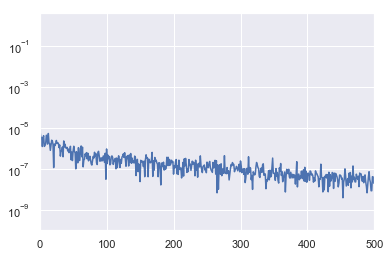

In [40]:
plt.plot(fourier_spectrum)
plt.yscale('log')
ax = plt.gca()
_ = ax.set_xlim((0,500))

RMS dm/dz is 0.08852863302152059 ppm/mm.
Mean dm/dz is -3.1456319031046104e-19 ppm/mm.
(36000,)


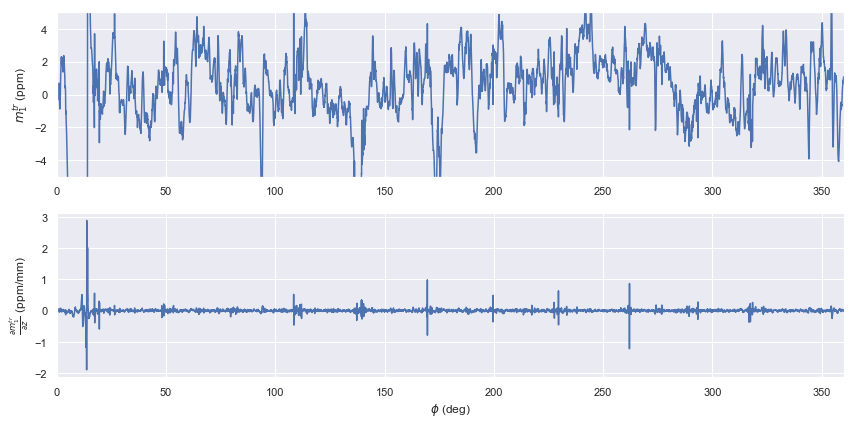

In [15]:
rms_dm_dz = np.std(dm_dz)
print 'RMS dm/dz is ' + str(rms_dm_dz) + ' ppm/mm.'
print 'Mean dm/dz is ' + str(np.mean(dm_dz)) + ' ppm/mm.'
print dm_dz.shape

fig, axs = plt.subplots(2,1)
plt.sca(axs[0])
plt.plot(new_phis, new_ms)
axs[0].set_xlim((0,360))
axs[0].set_ylim((-5,5))
axs[0].set_ylabel(r'$m_1^{tr}$ (ppm)')
# axs[0].set_ylim((750,900))

plt.sca(axs[1])
plt.plot(new_phis, dm_dz)
axs[1].set_xlim((0,360))
axs[1].set_xlabel(r'$\phi$ (deg)')
axs[1].set_ylabel(r'$\frac{\partial m_1^{tr}}{\partial z}$ (ppm/mm)')
# axs[1].set_ylim((48000,56000))

# plt.sca(axs[2])
# plt.plot(old_phis, old_ms)
# axs[2].set_xlim((0,360))
# # axs[2].set_ylim((750,900))


fig.set_size_inches(12,6)
fig.tight_layout()

In [3]:
# calculate rms uncertainty for fixed probes after removing drift

def quad_fit(x, a, b, c):
    return a + b*x + c*x**2/2

fp_run = trfp.FixedProbeRun(3960)

Reading event 4360/4370 99.77%  
loop done: 100%                                    
Finished calculating all moments for 3640 events.                                                     


In [4]:
_, raw_times, raw_freqs = fp_run.fp_run.getBasics()
raw_times = raw_times/1.0e9

Reading event 4360/4370 99.77%  
loop done: 100%                                    


In [5]:
rms_uncs = np.zeros(378)

num_points = 100
points_offset = 1000

start_time = np.min(raw_times[0,:])
times = raw_times[points_offset:points_offset+num_points, :] - start_time
freqs = raw_freqs[points_offset:points_offset+num_points, :]



for probe in np.arange(378):
    coeffs, _ = scipy.optimize.curve_fit(quad_fit, times[:,probe], freqs[:,probe])
    drift = quad_fit(times[:, probe], coeffs[0], coeffs[1], coeffs[2])
    resids = freqs[:,probe] - drift
    rms_uncs[probe] = np.std(resids)
    print '\rProbe ' + str(probe) + '.',

Probe 64.                        

/home/aetb/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Probe 377.                                                            


0.23976697363958932
0.21801153966673922
0.06882578777068804


Text(0.5,1,'Fixed Probe Shot Noise Histogram')

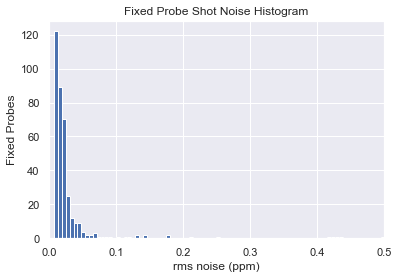

In [41]:
var_uncs = rms_uncs**2

moment_uncs = np.empty((72,6))
moment_uncs[:] = np.nan

for st in np.arange(72):
    var_temp = var_uncs[trfp.STATION_PROBE_ID[st]]
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        if num_probes == 6:
            moment_uncs[st, m] = np.dot(np.abs(trfp.THETA_FP_6[m]), var_temp)
        else:
            moment_uncs[st, m] = np.dot(np.abs(trfp.THETA_FP_4[m]), var_temp)
moment_uncs = np.sqrt(moment_uncs)

print np.std(rms_uncs/61.79)
print np.std(moment_uncs[:,0]/61.79)
print np.mean(moment_uncs[:,0]/61.79)
# print np.round(moment_uncs/61.79,3)

plt.hist(rms_uncs/61.79,500)
ax = plt.gca()
ax.set_xlim((0,0.5))
ax.set_ylabel('Fixed Probes')
ax.set_xlabel('rms noise (ppm)')
ax.set_title('Fixed Probe Shot Noise Histogram')

0.01382497165316501
[0.03499468 0.01316572 0.00903011 0.41872223 0.68733971 1.81704616
 0.10032868 0.0168356  0.01098314 0.25110678 0.08890708 0.42722773
 0.05114929 0.01205507 0.0137782  0.64533605 0.83162805 2.17199749
 0.01423205 0.01871189 0.03192925 2.87860858 0.78876056 0.49819484
 0.13029635 0.01299757 0.01658708 1.13171638 0.43637304 0.01805106
 0.03490267 0.01075454 0.01281343 0.79809886 0.42558105 0.79680502
 0.01252077 0.01213038 0.01056036 0.01266991 0.01186905 0.01247006
 0.01696929 0.06447876 0.01585963 0.02002196 0.01799156 0.01569115
 0.01346818 0.01677141 0.02063515 0.01691187 0.01304714 0.01002755
 0.01555909 0.0246397  0.01565721 0.01218003 0.00991399 0.01925461
 0.0133414  0.01883186 0.01575441 0.0178275  0.01683049 0.01581734
 0.01001467 0.01368055 0.01969183 0.02195252 0.01904437 0.0506565
 0.01550072 0.02191474 0.17787544 0.11203766 0.02163591 0.01631876
 0.02850927 0.0148012  0.01424684 0.02604784 0.01047078 0.01495876
 0.01426582 0.01010147 0.02416574 0.0128138

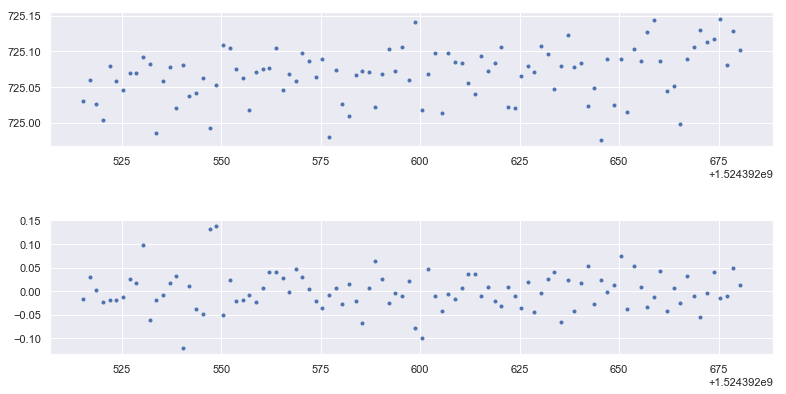

In [7]:
print rms_uncs[137]/61.79

print rms_uncs/61.79


fig, axs = plt.subplots(2,1)
plt.sca(axs[0])
plt.plot(times[:,0], freqs[:,0]/61.79, '.')
plt.sca(axs[1])
plt.plot(times[:,0], resids/61.79, '.')
fig.tight_layout()
fig.set_size_inches(12,6)